In [ ]:
import sys
import h5py
from pathlib import Path
import zipfile, os, sys
import numpy as np
from collections import defaultdict, Counter
import re
import json
import pandas as pd
from functools import partial
import torch
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm import tqdm

ROOT = Path.cwd().parent          
SRC  = ROOT / "src"
sys.path.insert(0, str(SRC))      

from fashiongen_h5_loader import (
    ensure_h5_ready, build_vocab_from_h5, build_material_vocab_from_h5, make_loaders_with_existing_val, read_label_ids_from_h5
)

from multitask_fashion_model import (
    TextTokenizer, collate_batch,
    MultiTaskConfig, FashionMultiTaskModel, one_training_step, worker_init_fn
)    

import constant as c

%load_ext autoreload
%autoreload 2

# 1. Import Data

In [2]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cpu


In [3]:
DATA_DIR = ROOT / "data"
assert DATA_DIR.exists(), f"Missing data dir: {DATA_DIR}"
print("DATA_DIR:", DATA_DIR)

DATA_DIR: /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data


In [5]:
# 1) Unzip both train/validation if needed; search h5 recursively
h5s = []
for zp in sorted(DATA_DIR.glob("*.zip")):
    out_dir = DATA_DIR / zp.stem
    out_dir.mkdir(parents=True, exist_ok=True)
    # extract only missing files
    with zipfile.ZipFile(zp, "r") as zf:
        for m in zf.infolist():
            # skip macOS metadata
            if m.filename.startswith("__MACOSX/"): 
                continue
            target = out_dir / m.filename
            if not target.exists():
                zf.extract(m, out_dir)
    # collect any .h5 inside (recursively)
    h5s.extend(sorted(out_dir.rglob("*.h5")))

In [6]:
h5s = sorted(set(h5s))
print("Found H5 files:")
for p in h5s: print(" -", p)

Found H5 files:
 - /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data/fashiongen_256_256_train.h5/fashiongen_256_256_train.h5
 - /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data/fashiongen_256_256_validation.h5/fashiongen_256_256_validation.h5


In [7]:
# 2) Identify splits by filename
lower = [p.name.lower() for p in h5s]
train_h5 = next((str(p) for p in h5s if "train" in p.name.lower()), None)
val_h5   = next((str(p) for p in h5s if "val" in p.name.lower() or "validation" in p.name.lower()), None)
test_h5  = next((str(p) for p in h5s if "test" in p.name.lower()), None)
print("train_h5:", train_h5)
print("val_h5  :", val_h5)
print("test_h5 :", test_h5)


train_h5: /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data/fashiongen_256_256_train.h5/fashiongen_256_256_train.h5
val_h5  : /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data/fashiongen_256_256_validation.h5/fashiongen_256_256_validation.h5
test_h5 : None


In [8]:
# 3.1) Build label vocab from train 
label_vocab_path = ROOT / "data/label_vocab.json"
_ = build_vocab_from_h5(
    train_h5,
    label_key="input_category",  
    add_other=True,
    min_count=5,
    out_json=str(label_vocab_path)
)

[vocab:input_category] Saved 49 labels to /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data/label_vocab.json


In [9]:
# 3.2) Build gender vocab from train 
gender_vocab_path = ROOT / "data/gender_vocab.json"
_ = build_vocab_from_h5(
    train_h5,
    label_key="input_gender",  
    add_other=False,
    min_count=5,
    out_json=str(gender_vocab_path)
)

[vocab:input_gender] Saved 2 labels to /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data/gender_vocab.json


In [11]:
# 3.3) Build material vocab from train 
mat_vocab_path = ROOT / "data/material_vocab.json"
_ = build_material_vocab_from_h5(
    train_h5,
    composition_key="input_composition",
    clothing_only=False,
    min_count=10,     # tune: 10, 25, 50…
    top_k=100,         # tune: 30–100
    add_other=True,
    out_json=str(mat_vocab_path),
)

[material_vocab] kept 44 tokens → /Users/jiaqingzhang/Downloads/GT_DL/project/Shop-Till-You-Drop/data/material_vocab.json


In [18]:
# 4) Build datasets/loaders
META_KEYS = ("input_category", "input_name","input_description","input_gender")  

train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = make_loaders_with_existing_val(
    train_h5=train_h5,
    val_h5=val_h5,
    vocab_label_json=str(label_vocab_path),
    vocab_gender_json=str(gender_vocab_path),
    material_vocab_json=str(mat_vocab_path),    
    composition_key="input_composition",
    materials_clothing_only=True,
    image_key="input_image",
    label_key="input_category",
    caption_key_candidates=("input_name","input_description","input_concat_description","caption","descriptions"),
    label_key_candidates=("input_category","category","class","label"),
    meta_keys=META_KEYS,
    meta_prefix="input_",
    image_size=224,
    train_ratio=0.8,
    batch_size=64,
    num_workers=8,
    normalize="imagenet",
)
print("train/val/test lens:", len(train_ds), len(val_ds), len(test_ds))

train/val/test lens: 208375 32528 52115


In [21]:
print("image_key:", train_ds.image_key)
print("label_key:", train_ds.label_key)
print("caption_key:", train_ds.caption_key)
print("composition_key:", train_ds.composition_key)

image_key: input_image
label_key: input_category
caption_key: input_name
composition_key: input_composition


In [20]:
with h5py.File(train_h5, "r") as f:
    for k in [train_ds.image_key, train_ds.label_key, train_ds.caption_key]:
        if k is None: 
            continue
        d = f[k]
        print(f"{k}: shape={getattr(d,'shape',None)}, dtype={getattr(d,'dtype',None)}")

input_image: shape=(260490, 256, 256, 3), dtype=uint8
input_category: shape=(260490, 1), dtype=|S100
input_name: shape=(260490, 1), dtype=|S100


In [22]:
# 5) Batch sanity
b = next(iter(train_loader))
print(b["image"].shape, b["label"].shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [24]:
print(b["image"].shape, b["label"][:8], b["gender"][:8])

torch.Size([64, 3, 224, 224]) tensor([19, 30, 45, 42,  9, 42, 45, 35]) tensor([1, 0, 1, 1, 1, 0, 1, 0])


# 2 Check Label Dist

In [25]:
# 1) Build id → name map
with open(label_vocab_path) as f:
    vocab = json.load(f)
    
id2label = {int(v): k for k, v in vocab.items()}

In [26]:
with open(gender_vocab_path) as f:
    gen_vocab = json.load(f)
id2gen = {int(v): k for k, v in gen_vocab.items()}

In [27]:
print("vocab size:", len(vocab))
print("first keys:", list(vocab)[:10])

vocab size: 49
first keys: ['__other__', 'backpacks', 'bag accessories', 'belts & suspenders', 'blankets', 'boat shoes & moccasins', 'boots', 'briefcases', 'clutches & pouches', 'dresses']


In [19]:
# 2) TRAIN: read all label ids from the train .h5, then subset to your dataset's keep_idx
train_labels_all = read_label_ids_from_h5(train_h5, label_key="input_category", vocab_json=str(label_vocab_path))
train_labels = train_labels_all[np.asarray(train_ds.keep_idx)]

In [20]:
# 3) VAL / TEST (if you built test from train, skip keep_idx for val_h5)
val_labels   = read_label_ids_from_h5(val_h5,   label_key="input_category", vocab_json=str(label_vocab_path))
test_labels  = read_label_ids_from_h5(train_h5, label_key="input_category", vocab_json=str(label_vocab_path))
test_labels  = test_labels[np.asarray(test_ds.keep_idx)]   

In [21]:
# 4) Make pretty tables
def counts_table(labels_np):
    s = pd.Series(labels_np)
    tbl = (s.value_counts()
             .rename_axis("label_id")
             .reset_index(name="n")
             .assign(category=lambda df: df["label_id"].map(id2label))
             .sort_values("n", ascending=False)
             .reset_index(drop=True))
    return tbl[["category","n","label_id"]]


train_counts = counts_table(train_labels)
val_counts   = counts_table(val_labels)
test_counts  = counts_table(test_labels)

In [22]:

print("TRAIN (top 20):")
print(train_counts.head(20).to_string(index=False))

print("\nVAL (top 20):")
print(val_counts.head(20).to_string(index=False))

print("\nTEST (top 20):")
print(test_counts.head(20).to_string(index=False))

TRAIN (top 20):
       category     n  label_id
           tops 38211        45
       sweaters 35672        42
jackets & coats 28028        19
          pants 18584        30
          jeans 10868        20
         shirts  9118        35
       sneakers  8382        39
        dresses  7566         9
         shorts  5932        36
  shoulder bags  5561        37
         skirts  5527        38
        jewelry  3946        21
           hats  3636        17
          boots  3612         6
          flats  3084        15
        sandals  2812        33
      backpacks  2286         1
suits & blazers  2276        41
        eyewear  1995        13
      tote bags  1824        46

VAL (top 20):
       category    n  label_id
           tops 5944        45
       sweaters 5602        42
jackets & coats 4357        19
          pants 2910        30
          jeans 1694        20
         shirts 1418        35
       sneakers 1306        39
        dresses 1184         9
         shorts  9

# 3. Quick Peek of the Dataset

In [58]:
import json, re, numpy as np, h5py
from pathlib import Path

# --- helpers copied from your loader ---
def _decode_bytes(x):
    import numpy as np
    if isinstance(x, np.void):
        b = bytes(x)
    elif isinstance(x, (bytes, bytearray, np.bytes_)):
        b = bytes(x)
    else:
        return str(x)
    b = b.split(b"\x00", 1)[0]
    for enc in ("utf-8", "latin-1"):
        try: return b.decode(enc)
        except UnicodeDecodeError: pass
    return b.decode("utf-8", errors="ignore")

def _as_scalar(x):
    import numpy as np
    if isinstance(x, np.ndarray):
        return x.squeeze().item() if x.ndim > 0 else x.item()
    return x

def _norm(s: str) -> str:
    return re.sub(r"\s+", " ", str(s).strip().lower())

# --- load vocab actually used by the dataset ---
with open(label_vocab_path) as f:
    vocab = json.load(f)
print("vocab size:", len(vocab))
print("first 10 vocab keys:", list(vocab.keys())[:10])

# --- peek raw/decoded/normalized vs membership ---
with h5py.File(train_h5, "r") as f:
    d = f["input_category"]   # change if needed
    N = d.shape[0]
    idxs = np.random.default_rng(0).choice(N, size=20, replace=False)
    rows = []
    for i in idxs:
        raw = _as_scalar(d[i])
        dec = _decode_bytes(raw)
        norm = _norm(dec)
        rows.append((i, dec, norm, norm in vocab))
rows[:5], sum(r[3] for r in rows)

vocab size: 49
first 10 vocab keys: ['__other__', 'backpacks', 'bag accessories', 'belts & suspenders', 'blankets', 'boat shoes & moccasins', 'boots', 'briefcases', 'clutches & pouches', 'dresses']


([(237756, 'FLATS', 'flats', True),
  (80181, 'TOPS', 'tops', True),
  (70272, 'DRESSES', 'dresses', True),
  (243577, 'SKIRTS', 'skirts', True),
  (133137, 'PANTS', 'pants', True)],
 20)

In [59]:
with open(label_vocab_path) as f: vocab = json.load(f)
print("vocab size:", len(vocab))
print("has input categories like 'dress'?", any("dress" in k for k in vocab.keys()))

vocab size: 49
has input categories like 'dress'? True


In [67]:
id2label

{0: '__other__',
 1: 'backpacks',
 2: 'bag accessories',
 3: 'belts & suspenders',
 4: 'blankets',
 5: 'boat shoes & moccasins',
 6: 'boots',
 7: 'briefcases',
 8: 'clutches & pouches',
 9: 'dresses',
 10: 'duffle & top handle bags',
 11: 'duffle bags',
 12: 'espadrilles',
 13: 'eyewear',
 14: 'fine jewelry',
 15: 'flats',
 16: 'gloves',
 17: 'hats',
 18: 'heels',
 19: 'jackets & coats',
 20: 'jeans',
 21: 'jewelry',
 22: 'jumpsuits',
 23: 'keychains',
 24: 'lace ups',
 25: 'lingerie',
 26: 'loafers',
 27: 'messenger bags',
 28: 'messenger bags & satchels',
 29: 'monkstraps',
 30: 'pants',
 31: 'pocket squares & tie bars',
 32: 'pouches & document holders',
 33: 'sandals',
 34: 'scarves',
 35: 'shirts',
 36: 'shorts',
 37: 'shoulder bags',
 38: 'skirts',
 39: 'sneakers',
 40: 'socks',
 41: 'suits & blazers',
 42: 'sweaters',
 43: 'swimwear',
 44: 'ties',
 45: 'tops',
 46: 'tote bags',
 47: 'travel bags',
 48: 'underwear & loungewear'}

In [60]:
print("len(train_ds):", len(train_ds))
print("keep_idx example:", train_ds.keep_idx[:5], "max raw:", int(np.max(train_ds.keep_idx)))

len(train_ds): 208375
keep_idx example: [ 42290 127284  20656  74607 107000] max raw: 260489


In [61]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm_img(img_t: torch.Tensor, norm="imagenet"):
    if norm == "imagenet":
        x = img_t * IMAGENET_STD + IMAGENET_MEAN
    elif norm == "gan":
        x = (img_t * 0.5) + 0.5
    else:
        x = img_t
    return x.clamp(0,1)

def show_samples(ds, idxs=None, n=8, ncols=4, norm="imagenet", id2label=None, figsize=(14, 8)):
    """
    idxs refer to **dataset indices**: 0..len(ds)-1.
    If idxs is None, we sample uniformly from that range.
    """
    N = len(ds)
    if idxs is None:
        n = min(n, N)
        idxs = np.random.default_rng(0).choice(np.arange(N), size=n, replace=False)
    else:
        idxs = [int(i) for i in idxs]
        for i in idxs:
            if not (0 <= i < N):
                raise IndexError(f"Dataset index {i} out of range [0, {N})")

    n = len(idxs)
    ncols = min(ncols, n)
    nrows = (n + ncols - 1) // ncols

    plt.figure(figsize=figsize)
    for pos, i in enumerate(idxs, 1):
        ex = ds[i]  # safe: dataset index
        img = denorm_img(ex["image"], norm=norm).permute(1,2,0).cpu().numpy()
        y = ex["label"]
        yname = id2label.get(int(y), str(y)) if id2label is not None else str(y)
        cap = ex.get("caption", "")
        cap = cap if isinstance(cap, str) else str(cap)
        if len(cap) > 80: cap = cap[:80] + "…"

        ax = plt.subplot(nrows, ncols, pos)
        ax.imshow(img); ax.axis("off")
        ax.set_title(f"{y} | {yname}", fontsize=10)
        ax.set_xlabel(cap, fontsize=9)
    plt.tight_layout()
    plt.show()

def show_by_raw_index(ds, raw_idxs, **kw):
    """
    Peek items by **raw H5 indices** (values inside ds.keep_idx).
    We convert each raw index to its dataset index first.
    """
    raw_idxs = [int(r) for r in raw_idxs]
    keep = np.asarray(ds.keep_idx)
    inv = {int(k): j for j, k in enumerate(keep)}  # raw->dataset
    ds_idxs = []
    missing = []
    for r in raw_idxs:
        j = inv.get(int(r))
        if j is None:
            missing.append(r)
        else:
            ds_idxs.append(j)
    if missing:
        print(f"(skipped {len(missing)} raw indices not in subset): {missing[:10]}")
    return show_samples(ds, idxs=ds_idxs, **kw)

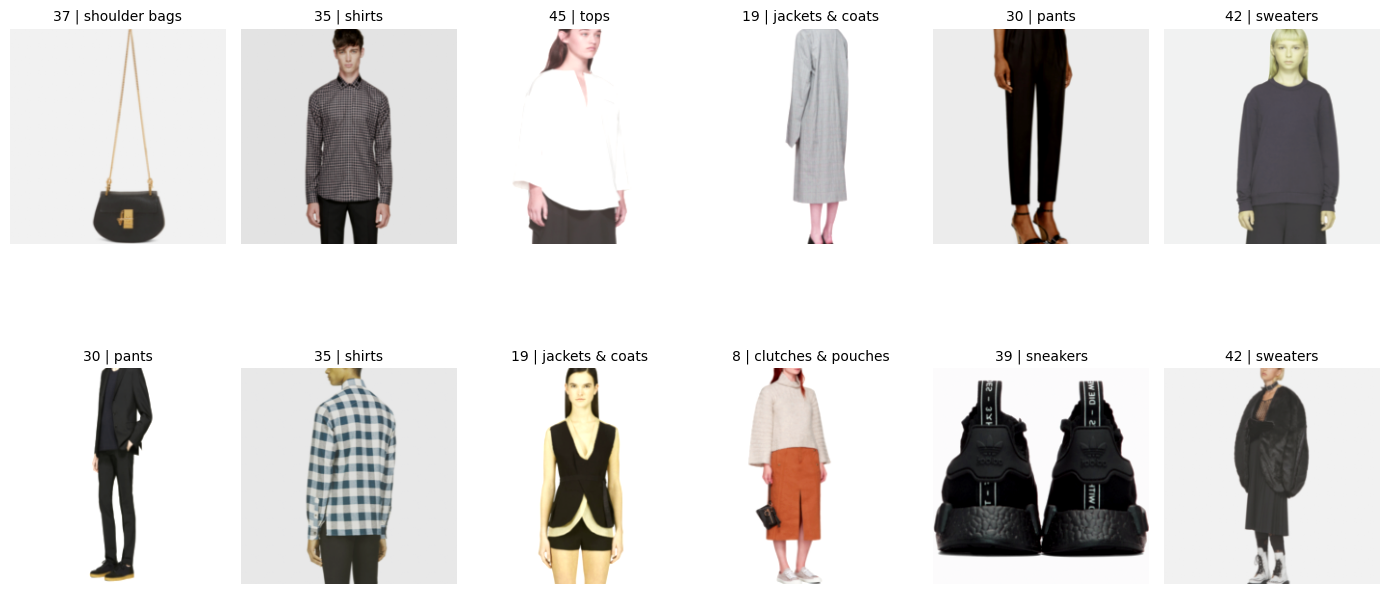

In [68]:
show_samples(train_ds, n=12, ncols=6, norm="imagenet", id2label=id2label)


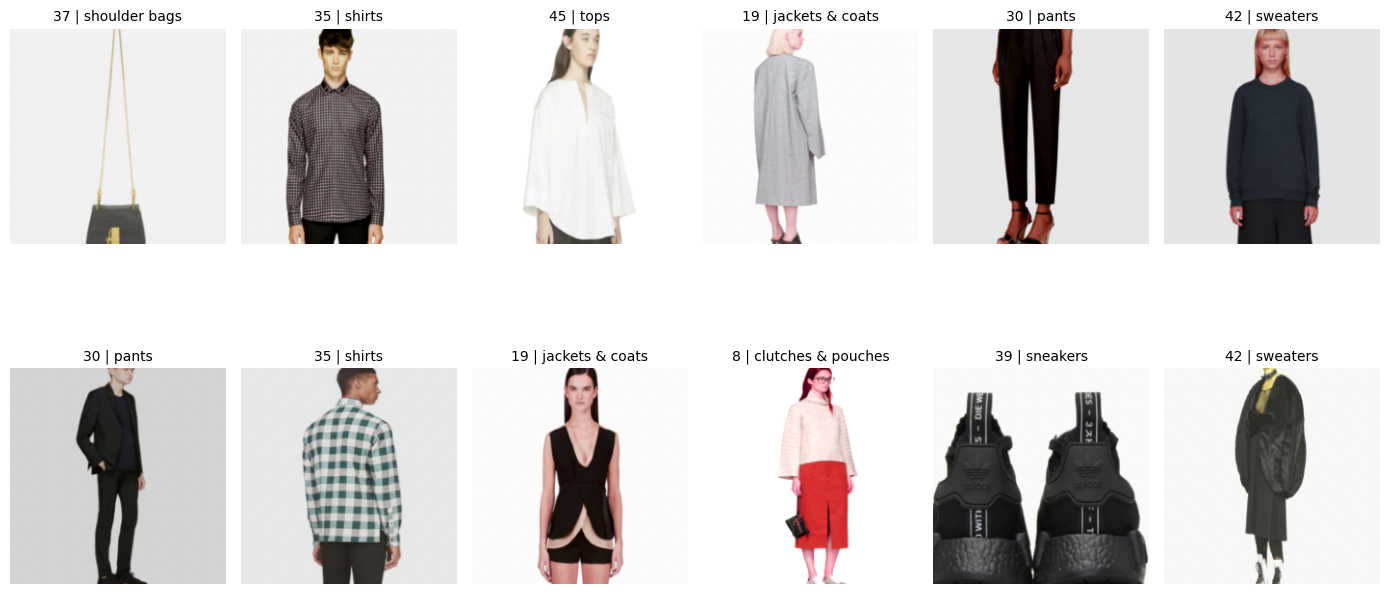

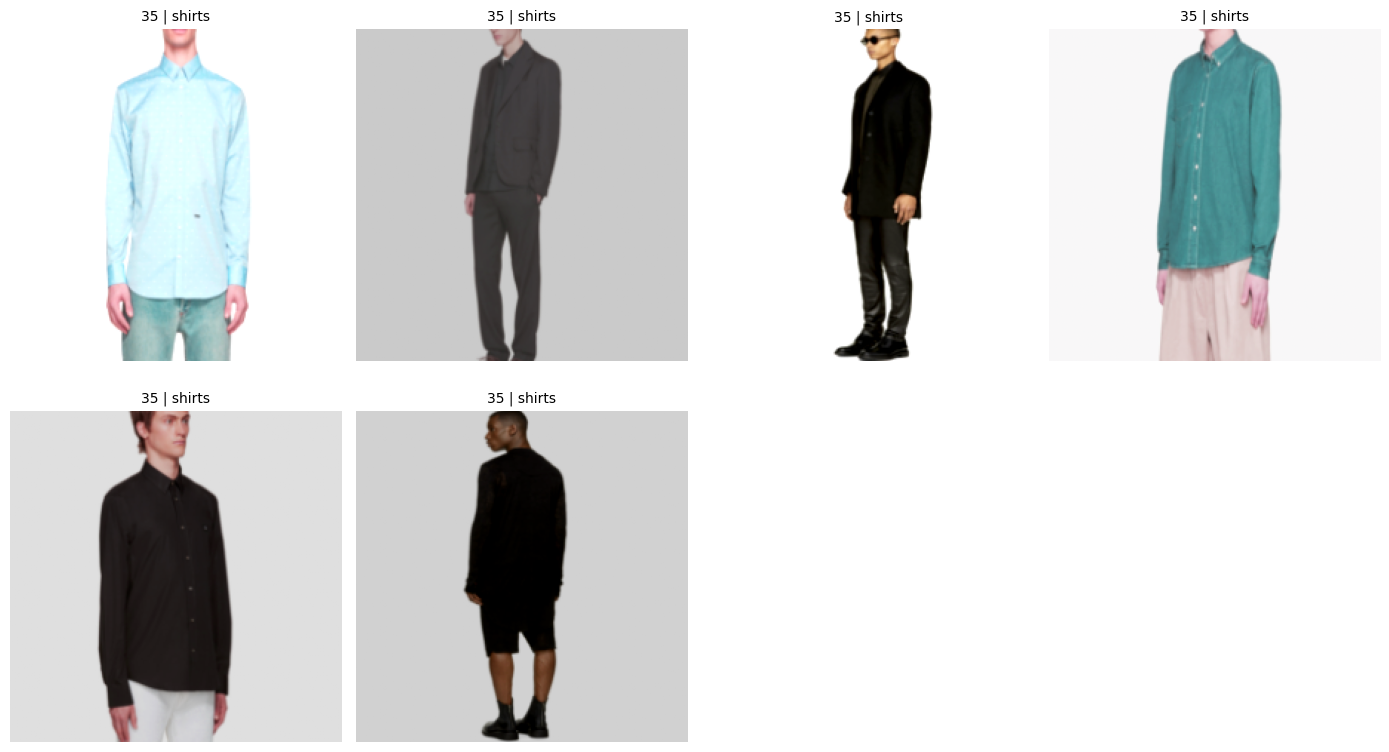

(skipped 1 raw indices not in subset): [12345]


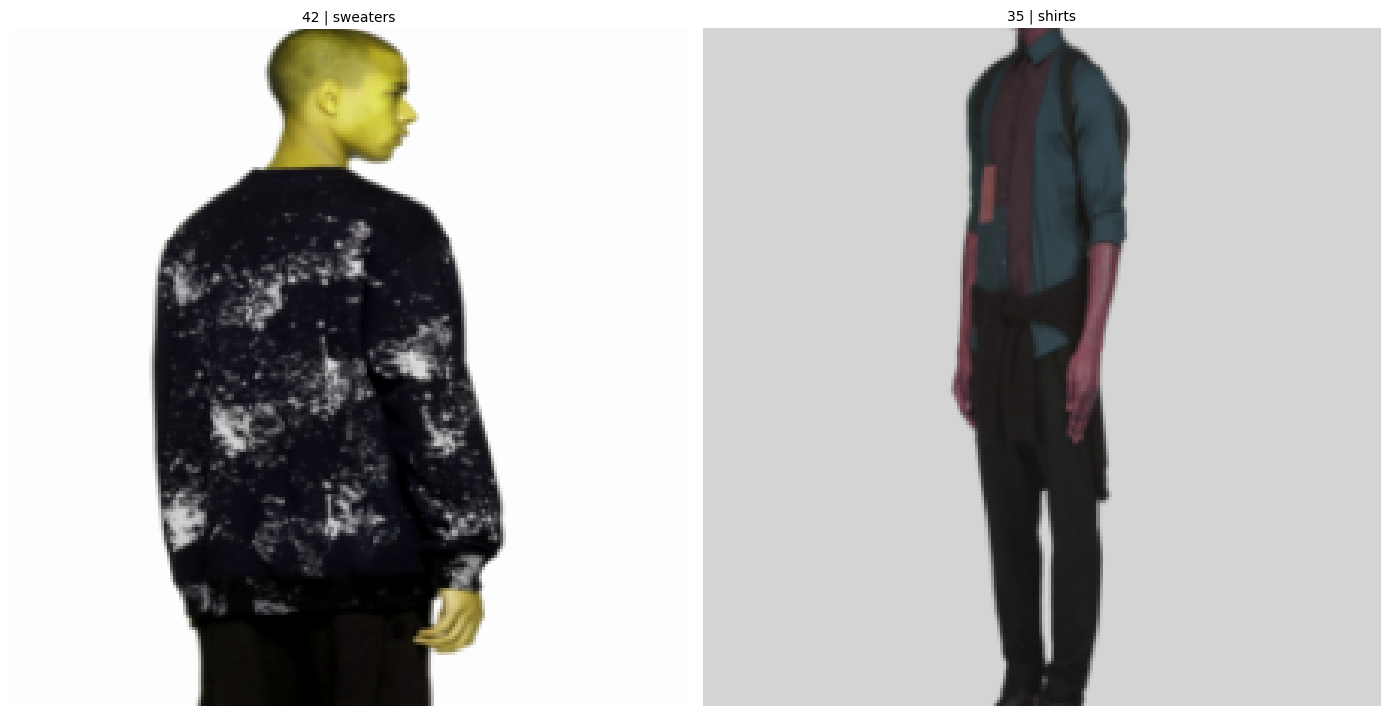

In [69]:
# Random dataset indices
show_samples(train_ds, n=12, ncols=6, norm="imagenet", id2label=id2label)

# Exact dataset indices
show_samples(train_ds, idxs=[0,1,2,3,4,5], id2label=id2label)

# Peek by raw H5 indices (from the original file):
show_by_raw_index(train_ds, raw_idxs=[257594, 100, 12345], id2label=id2label)

In [16]:
print("Dataset length:", len(train_ds))
for i in random.sample(range(len(train_ds)), k=5):
    ex = train_ds[i]
    cat = id2label.get(int(ex["label"]), ex["label"])
    gen = id2gen.get(int(ex["gender"]), ex["gender"])
    cap = (ex["caption"] or "")[:140].replace("\n"," ")
    print(f"[{i}] category={cat} | gender={gen} | caption='{cap}'")

Dataset length: 208375
[62207] category=pants | gender=men | caption='Black Wool Slim Trousers'
[171959] category=jewelry | gender=women | caption='Black Crystal 'Boys' Clip-On Earrings'
[196572] category=boots | gender=women | caption='White Lace-Up Boots'
[123701] category=jackets & coats | gender=men | caption='Black Puffer Wijay Jacket'
[158432] category=jumpsuits | gender=women | caption='Black Sleeveless Bodybag Jumpsuit'


In [ ]:

# def dataset_name_dist(ds, sample=None, top=30):
#     idxs = range(len(ds)) if sample is None else random.sample(range(len(ds)), sample)
#     cnt = Counter()
#     for i in idxs:
#         s = ds[i]["caption"]  # caption is set to input_name in your setup
#         s = s.strip().lower()
#         if s: cnt[s] += 1
#     total = sum(cnt.values())
#     print(f"unique: {len(cnt):,} | counted: {total:,}")
#     for k,v in cnt.most_common(top):
#         print(f"{v:7d}  {v/total:6.2%}  {k}")
#     return cnt

# # Usage (after building train_ds)
# cnt_ds = dataset_name_dist(train_ds, sample=None, top=30)
# cnt_ds

unique: 52,083 | counted: 208,375
    327   0.16%  black logo t-shirt
    284   0.14%  white logo t-shirt
    176   0.08%  black leather biker jacket
    146   0.07%  black wool trousers
    140   0.07%  white poplin shirt
    126   0.06%  black wide-leg trousers
    107   0.05%  black slim jeans
     97   0.05%  black skinny jeans
     95   0.05%  black logo hoodie
     93   0.04%  black logo sweatshirt
     77   0.04%  black logo lounge pants
     76   0.04%  grey logo t-shirt
     67   0.03%  black logo pullover
     67   0.03%  black logo cap
     66   0.03%  black drawstring trousers
     64   0.03%  black zip-up hoodie
     64   0.03%  black nylon bomber jacket
     63   0.03%  black pleated trousers
     62   0.03%  black cropped trousers
     62   0.03%  white heart patch t-shirt
     61   0.03%  blue slim jeans
     60   0.03%  black lounge pants
     59   0.03%  black denim jacket
     59   0.03%  blue denim jacket
     57   0.03%  black biker jeans
     57   0.03%  black lon

Counter({'black logo t-shirt': 327,
         'white logo t-shirt': 284,
         'black leather biker jacket': 176,
         'black wool trousers': 146,
         'white poplin shirt': 140,
         'black wide-leg trousers': 126,
         'black slim jeans': 107,
         'black skinny jeans': 97,
         'black logo hoodie': 95,
         'black logo sweatshirt': 93,
         'black logo lounge pants': 77,
         'grey logo t-shirt': 76,
         'black logo pullover': 67,
         'black logo cap': 67,
         'black drawstring trousers': 66,
         'black zip-up hoodie': 64,
         'black nylon bomber jacket': 64,
         'black pleated trousers': 63,
         'black cropped trousers': 62,
         'white heart patch t-shirt': 62,
         'blue slim jeans': 61,
         'black lounge pants': 60,
         'black denim jacket': 59,
         'blue denim jacket': 59,
         'black biker jeans': 57,
         'black long sleeve t-shirt': 57,
         'black wool lounge pants': 

# 4. Multitask Fashion Model

In [ ]:
# 1) Build tokenizer from the train dataset captions
captions = [train_ds[i]["caption"] for i in tqdm(range(len(train_ds)))]

In [ ]:
tok =  TextTokenizer.build_from_captions(captions=captions, min_freq=2, max_size=30000)

TypeError: TextTokenizer.build_from_captions() missing 1 required positional argument: 'cls'

In [31]:
print(len(tok.stoi), list(tok.stoi)[:10])


13351 ['<pad>', '<bos>', '<eos>', '<unk>', 'black', 'white', 't-shirt', '&', 'jacket', 'grey']


In [32]:
ids = tok.encode("simple test caption")
print(ids, tok.decode(ids))

[1, 712, 5856, 3, 2] simple test <unk>


In [15]:
captions

['Light Blue Relax Dan Polka Dot Shirt',
 'Black Field Shirt',
 'Green Military Shirt',
 'Indigo Denim Isherwood Shirt',
 'Black Jeffrey Pop Face Shirt',
 'Black Slub Opaled Cardigan',
 'Blue Silk Convertible Shirt',
 'Black Contrast Stripe Shirt',
 'Black Linen Half Double Body Shirt',
 'White Classic Shirt',
 'White Coordinates Shirt',
 'Indigo Dobby Shirt',
 'Grey Plaid Flannel Shirt',
 'White Albacore Merrick Shirt',
 'Grey Plaid Worker Shirt',
 'White Grosgrain Shirt',
 'Navy Typewriter Pattern Shirt',
 'White Classic Shirt',
 'Black Split Neck Shirt',
 'Blue Chambray D-Carry Shirt',
 'Black & White Babycat Spot Print Shirt',
 'Grey & Black Water Print Button-Up Shirt',
 'Black Drawstring Collar Shirt',
 'Blue Long Sleeve Button Down Sash Shirt',
 'Black Mesh-Paneled Shirt',
 'Black Wool Armband Shirt',
 'White Drawstring Shirt',
 'Black Cotton & Silk Faun Tunic Shirt',
 'Black Lewisham Shirt',
 'White Black-Banded Shirt',
 'Black & Ivory Yokohama Shirt',
 'White Monster Logo Prin

In [39]:
# 2) Create model config (enable/disable heads based on your vocabs)
cfg = MultiTaskConfig(
    backbone="vit_base_patch16_224",   # or "resnet50" if using torchvision fallback
    proj_dim=512,
    num_categories=49,    # e.g., len(category_vocab) or None
    num_genders=2,    # e.g., len(gender_vocab) or None
    vocab_size=len(tok.stoi),
    pad_id=tok.pad_id,
    caption_emb_dim=256,
    caption_layers=1,
    dropout=0.1,
    loss_w_category=1.0,
    loss_w_gender=0.5,
    loss_w_caption=1.0,
)
model = FashionMultiTaskModel(cfg).to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# 3) DataLoaders with collate
collate_fn = partial(
    collate_batch,           # the real implementation you already defined above
    tokenizer=tok,
    expect_category=(cfg.num_categories is not None),
    expect_gender=(cfg.num_genders is not None),
)


train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=8,
    pin_memory=True, persistent_workers=True, worker_init_fn=worker_init_fn,
    collate_fn=collate_fn,  
)
val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=8,
    pin_memory=True, persistent_workers=True, worker_init_fn=worker_init_fn,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8,
    pin_memory=True, persistent_workers=True, worker_init_fn=worker_init_fn,
    collate_fn=collate_fn,
)

print("Loaders rebuilt with custom collate:",
      len(train_ds), len(val_ds), len(test_ds))


Loaders rebuilt with custom collate: 208375 32528 52115


In [ ]:
# 4) Train step
opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)

epochs = 10
for epoch in tqdm(range(epochs), desc = 'Epochs'):
    batch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    
    for batch in batch_bar:
        metrics = one_training_step(model, batch, opt, cfg, device)
        batch_bar.set_postfix({k: f"{v:.4f}" for k, v in metrics.items()})

In [ ]:
# 5) Generate
model.eval()
with torch.no_grad():
    batch = next(iter(val_loader))
    imgs = batch["images"].to(device)
    gen_ids = model.generate(imgs, bos_id=tok.bos_id, eos_id=tok.eos_id, max_len=30)
    for i in range(min(3, imgs.size(0))):
        print("GEN:", tok.decode(gen_ids[i].tolist()))
        print("GT :", batch["cap_tgt"][i].tolist())  # token ids; decode 